<a href="https://colab.research.google.com/github/jiiinchoi/MAI-Lab./blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge

In [1]:
!pip uninstall -y opencv-python opencv-python-headless numpy
!pip install numpy==1.26.4
!pip install opencv-python-headless==4.8.1.78

# 교수님께서 주신대로 하니 자꾸 버전 오류가..

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires nu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.1.78 which is incompatible.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.1.78 which is incompatible.


In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [67]:
img = cv2.imread('light.png')
if img is None: raise Exception("영상파일이 없어요")

In [68]:
# 원본이 바뀌면 안되니까 다른 파일에 저장
orig = img
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 이진화 (어제 배운 내용)
thre, img_bin = cv2.threshold(img, thresh = 225, maxval = 255, type = cv2.THRESH_BINARY) # 225!

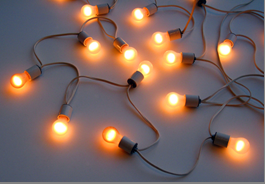

In [69]:
cv2_imshow(orig)

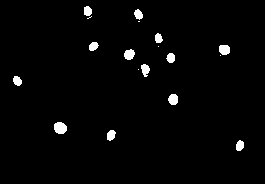

In [70]:
cv2_imshow(img_bin)

# Opening

In [71]:
# morphological 사용 (무엇을 사용해야할까요?)
# 전구 주변 작은 하얀 점 제거하려면 ? (안 하면 영역이 여러개 나온다)

kernel = np.ones((3,3),np.uint8)
img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)


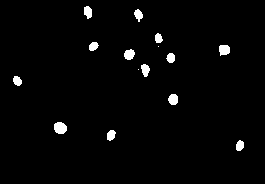

In [72]:
cv2_imshow(img_bin)

In [73]:
kernel = np.ones((3, 3), np.uint8)
img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel) # close -> open 으로

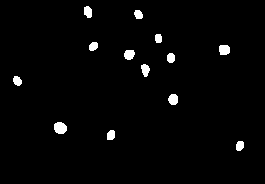

In [74]:
cv2_imshow(img_bin)

In [75]:
# 심심하면 몇 번 erosion과 dialation을 반복해보자~
erosion = cv2.erode(img_bin,kernel) # 아래에서 깎인 영상 확인
dilation = cv2.dilate(erosion,kernel) # 깎인 영상을 dilation 시킨게 opening이라고 했죠?

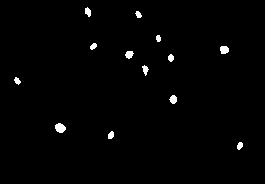

In [76]:
cv2_imshow(erosion)

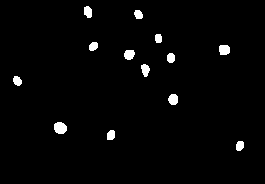

In [77]:
cv2_imshow(dilation)

In [78]:
retval, labels, stats, centroids= cv2.connectedComponentsWithStats(dilation)
print('retval=',retval) # 총 갯수

retval= 14


In [80]:
m=1 # 왜 m=1 부터일까요? label 0 은 background라서
while(m<retval):
  orig = cv2.circle(orig, (int(centroids[m,0]),int(centroids[m,1])) ,10 , (0,0,255), thickness=2)
  m=m+1

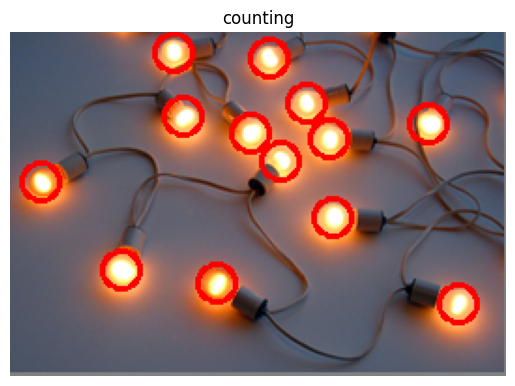

In [81]:
plt.imshow(orig[:,:,::-1])
plt.axis('off')
plt.title('counting')
plt.show()


# watershed

In [82]:
img = cv2.imread('coins.jpg')

In [83]:
# binaray image로 변환
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [84]:
# Morphology의 opening을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

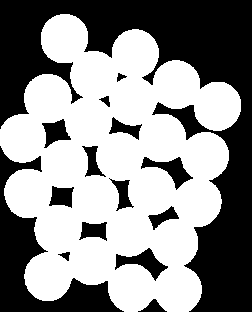

In [85]:
cv2_imshow(opening)

In [86]:
# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

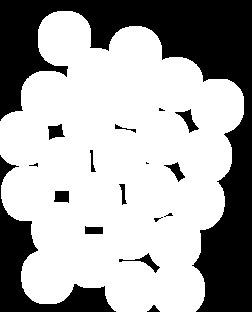

In [87]:
cv2_imshow(sure_bg)

In [98]:
#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

# 최대 거리값의 50% 이상만 남겨서
# 확실한 전경(Foreground) 영역만 추출
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

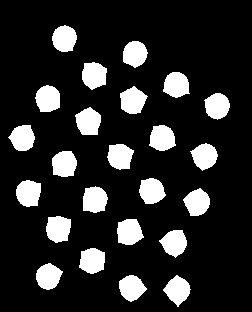

In [99]:
cv2_imshow(sure_fg)

In [100]:
# Background에서 Foregrand를 제외한 영역을 Unknow영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

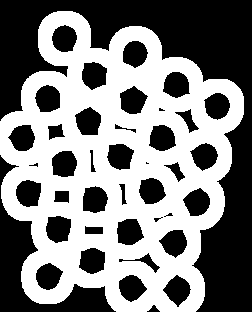

In [101]:
cv2_imshow(unknown)

In [102]:
# FG에 Labeling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

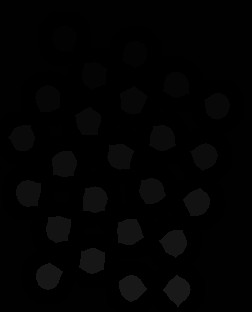

In [103]:
cv2_imshow(markers)

In [94]:
# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

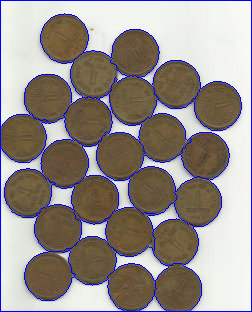

In [95]:
cv2_imshow(img)

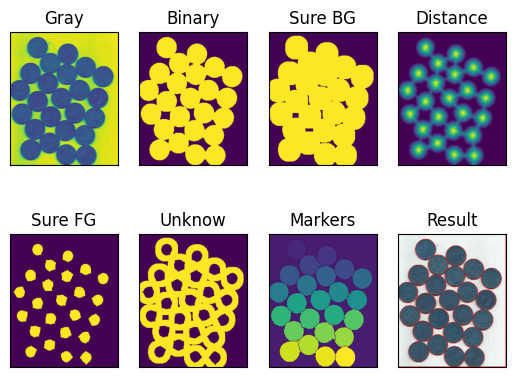

In [96]:
images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, img]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(8):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()